In [43]:
import pandas as pd
import joblib
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    average_precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import shap
import warnings

In [44]:
warnings.simplefilter("ignore", category=FutureWarning)  # Suppress only FutureWarnings
warnings.simplefilter("ignore", category=DeprecationWarning)  # Suppress DeprecationWarnings

In [45]:
df = pd.read_csv('data.csv')
target_col = 'Bankrupt?'
df.columns = df.columns.str.strip()
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [46]:
df.shape

(6819, 96)

In [47]:
df[target_col].value_counts()//2

Bankrupt?
0    3299
1     110
Name: count, dtype: int64

In [48]:
# set the target and features
X = df.drop("Bankrupt?", axis=1)
y = df["Bankrupt?"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

f1_init = f1_score(y_test, y_pred)
brier_score_init = brier_score_loss(y_test, y_pred)
roc_auc_init = roc_auc_score(y_test, y_pred)
precision_init = average_precision_score(y_test, y_pred)
accuracy_init = accuracy_score(y_test, y_pred)
recall_init = recall_score(y_test, y_pred)
conf_matrix_init = confusion_matrix(y_test, y_pred)

print("\nInit test")
print(f"Accuracy: {accuracy_init:.4f}")
print(f"Brier Score: {brier_score_init:.4f}")
print(f"Precision: {precision_init:.4f}")
print(f"Recall: {recall_init:.4f}")
print(f"F1 Score: {f1_init:.4f}")
print(f"AUC Score: {roc_auc_init:.4f}")
print(f"Confusion Matrix_init:\n{conf_matrix_init}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Init test
Accuracy: 0.9714
Brier Score: 0.0286
Precision: 0.2157
Recall: 0.3182
F1 Score: 0.4179
AUC Score: 0.6557
Confusion Matrix_init:
[[1311    9]
 [  30   14]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1320
           1       0.61      0.32      0.42        44

    accuracy                           0.97      1364
   macro avg       0.79      0.66      0.70      1364
weighted avg       0.97      0.97      0.97      1364



In [49]:
# Splitting data into training, validation sets, amd OOS(out of sample) test set
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size = 0.2,
    stratify=y,
    random_state=42
)

X_test, X_oos, y_test, y_oos = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    stratify=y_temp, 
    random_state=42
)

In [50]:
# Defining the XGBoost classifier 
model = xgb.XGBClassifier(
    objective="binary:logistic", 
    use_label_encoder=False,  
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)

c:\Users\thoma\Desktop\ML_API\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:17:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

 94%|=================== | 5132/5455 [00:12<00:00]       

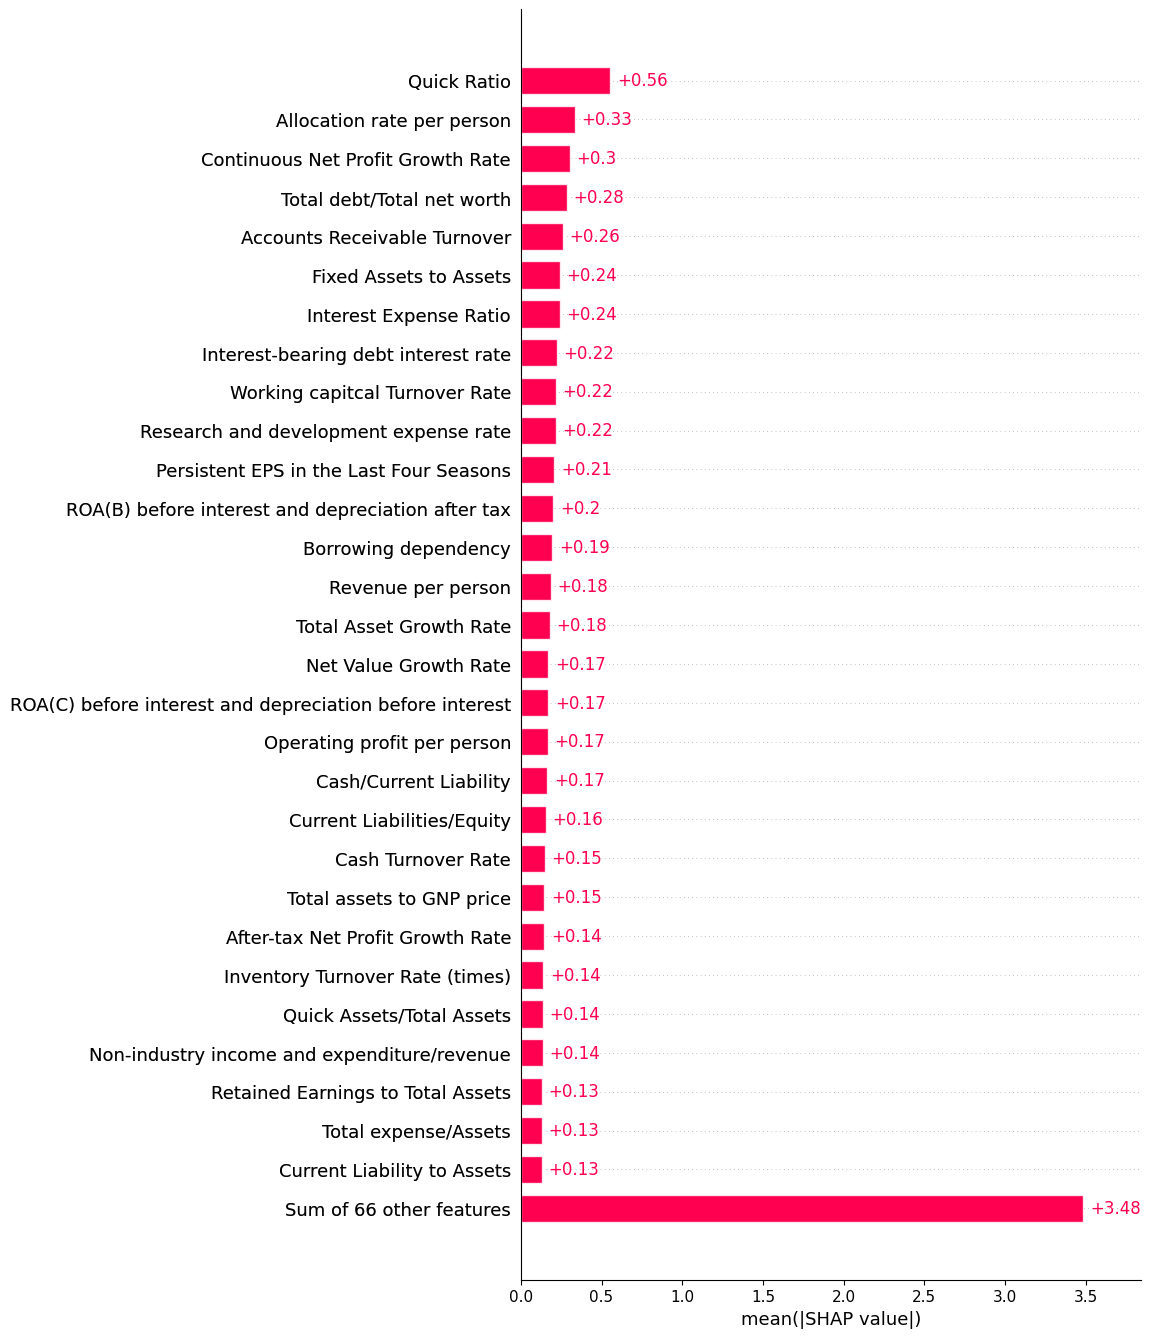

In [51]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": shap_importance
}).sort_values(by="Importance", ascending=False)

shap.plots.bar(shap_values, max_display=30)

In [52]:
selected_features = feature_importance_df["Feature"].values[:30]
X_train_sl = X_train[selected_features]

param_grs = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 500, 1000],
    "max_depth": [3, 6, 9],
    "gamma": [0.1, 0.3, 0.5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0.01, 0.1, 1],
    "reg_lambda": [0.1, 1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_model = XGBClassifier(
    objective="binary:logistic",
    booster="gbtree",
    use_label_encoder=False,
    eval_metric="auc",
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grs,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=0,
)

random_search.fit(X_train_sl, y_train)

print(f"Best Param: {random_search.best_params_}")

c:\Users\thoma\Desktop\ML_API\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:17:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Param: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.8}


In [53]:
model = random_search.best_estimator_

y_pred = model.predict(X_test[selected_features])
y_proba = model.predict_proba(X_test[selected_features])[:, 1]

In [54]:
f1 = f1_score(y_test, y_pred)
brier_score = brier_score_loss(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
precision = average_precision_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

oos_y_proba = model.predict_proba(X_oos[selected_features])[:, 1]
oos_y_pred = model.predict(X_oos[selected_features])
oos_f1 = f1_score(y_oos, oos_y_pred)
oos_roc_auc = roc_auc_score(y_oos, oos_y_proba)
oos_precision = average_precision_score(y_oos, oos_y_proba)
oos_conf_matrix = confusion_matrix(y_oos, oos_y_pred)

print("Test set evaluation:")
print(f"F1_score: {f1}")
print(f"Brier Score: {brier_score:.4f}")
print(f"ROC_AUC: {roc_auc}")
print(f"PRECISION: {precision}")
print(f"CONFUSION MATRIX: {conf_matrix}")

print("OOS evaluation:")
print(f"F1_score: {oos_f1}")
print(f"ROC_AUC: {oos_roc_auc}")
print(f"PRECISION: {oos_precision}")
print(f"CONFUSION MATRIX: {oos_conf_matrix}")

Test set evaluation:
F1_score: 0.375
Brier Score: 0.0210
ROC_AUC: 0.9698347107438017
PRECISION: 0.5810988814273101
CONFUSION MATRIX: [[656   4]
 [ 16   6]]
OOS evaluation:
F1_score: 0.5
ROC_AUC: 0.9476584022038568
PRECISION: 0.5258911024799121
CONFUSION MATRIX: [[658   2]
 [ 14   8]]


In [55]:
model.save_model("model.json")

In [56]:
# def calculate_psi(expected, actual, bins=10):
#     expected_percents, _ = np.histogram(expected, bins=bins, density=True)
#     actual_percents, _ = np.histogram(actual, bins=bins, density=True)

#     expected_percents += 1e-6  # Avoid division by zero
#     actual_percents += 1e-6  # Avoid division by zero

#     psi_values = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
#     return np.sum(psi_values)

# # Compute PSI for each feature
# psi_results = {}

# for feature in importance_df["Feature"]:
#     psi_train_test = calculate_psi(X_train[feature], X_test[feature])
#     psi_train_oos = calculate_psi(X_train[feature], X_oos[feature])
#     psi_test_oos = calculate_psi(X_test[feature], X_oos[feature])

#     psi_results[feature] = {"Train-Test": psi_train_test, "Train-OOS": psi_train_oos, "Test-OOS": psi_test_oos}

# # Convert PSI results to DataFrame
# psi_df = pd.DataFrame(psi_results).T
# psi_df = psi_df.sort_values(by="Train-Test", ascending=False)

# # Plot PSI Heatmap using Seaborn
# ax = sns.heatmap(psi_df, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)
# ax.set_title("PSI (Population Stability Index) Heatmap")

In [57]:
model.feature_names_in_

array(['Quick Ratio', 'Allocation rate per person',
       'Continuous Net Profit Growth Rate', 'Total debt/Total net worth',
       'Accounts Receivable Turnover', 'Fixed Assets to Assets',
       'Interest Expense Ratio', 'Interest-bearing debt interest rate',
       'Working capitcal Turnover Rate',
       'Research and development expense rate',
       'Persistent EPS in the Last Four Seasons',
       'ROA(B) before interest and depreciation after tax',
       'Borrowing dependency', 'Revenue per person',
       'Total Asset Growth Rate', 'Net Value Growth Rate',
       'ROA(C) before interest and depreciation before interest',
       'Operating profit per person', 'Cash/Current Liability',
       'Current Liabilities/Equity', 'Cash Turnover Rate',
       'Total assets to GNP price', 'After-tax Net Profit Growth Rate',
       'Inventory Turnover Rate (times)', 'Quick Assets/Total Assets',
       'Non-industry income and expenditure/revenue',
       'Retained Earnings to Total Asset

In [58]:
# Inference Test

In [59]:
X_oos

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
171,0.460245,0.509431,0.507575,0.595605,0.595605,0.998836,0.797238,0.809137,0.303538,0.781417,...,0.781655,0.001048,0.622837,0.595606,0.839116,0.277382,0.026663,0.564460,1,0.046069
1355,0.526642,0.583461,0.572622,0.601630,0.601565,0.999022,0.797484,0.809393,0.303578,0.781643,...,0.823573,0.048454,0.624198,0.601625,0.841922,0.277884,0.026885,0.565571,1,0.040454
2283,0.556476,0.640046,0.611649,0.615510,0.615510,0.999206,0.797708,0.809598,0.303586,0.781852,...,0.850324,0.002822,0.623329,0.615508,0.843933,0.278383,0.026791,0.565158,1,0.036382
4351,0.621265,0.671337,0.654104,0.633427,0.633542,0.999396,0.797891,0.809697,0.303508,0.781968,...,0.876571,0.001517,0.624299,0.633422,0.844805,0.276583,0.026792,0.565162,1,0.061132
1028,0.488032,0.550534,0.541785,0.604527,0.604419,0.998997,0.797461,0.809389,0.303591,0.781678,...,0.806348,0.051427,0.623736,0.604523,0.840852,0.279319,0.026998,0.565983,1,0.031106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5812,0.579681,0.626908,0.612774,0.607122,0.607122,0.999075,0.797560,0.809435,0.303602,0.781703,...,0.844150,0.000253,0.624127,0.607122,0.843727,0.279089,0.026791,0.565158,1,0.032195
6117,0.485058,0.552660,0.535896,0.594315,0.594402,0.998969,0.797523,0.809424,0.303759,0.781691,...,0.812349,0.012088,0.635101,0.594315,0.841007,0.276560,0.026797,0.565184,1,0.061749
4677,0.505094,0.553914,0.560576,0.604513,0.604780,0.999024,0.797437,0.809396,0.303493,0.781658,...,0.807381,0.007940,0.627482,0.604512,0.841046,0.280743,0.027032,0.566095,1,0.026202
3124,0.517574,0.573648,0.559184,0.624079,0.622407,0.999061,0.797851,0.809626,0.304139,0.781909,...,0.819869,0.006924,0.623909,0.624081,0.841629,0.277635,0.026815,0.565271,1,0.043000


In [60]:
X_oos.head(10).to_csv("Inference_test")

In [61]:
model = xgb.Booster()
model.load_model("model.json")

In [62]:
final_features = [
    "Quick Ratio", 
    "Allocation rate per person",
    "Continuous Net Profit Growth Rate",
    "Total debt/Total net worth",
    "Accounts Receivable Turnover",
    "Fixed Assets to Assets",
    "Interest Expense Ratio",
    "Interest-bearing debt interest rate",
    "Working capitcal Turnover Rate",
    "Research and development expense rate",
    "Persistent EPS in the Last Four Seasons",
    "ROA(B) before interest and depreciation after tax",
    "Borrowing dependency", 
    "Revenue per person",
    "Total Asset Growth Rate", 
    "Net Value Growth Rate",
    "ROA(C) before interest and depreciation before interest",
    "Operating profit per person", 
    "Cash/Current Liability",
    "Current Liabilities/Equity", 
    "Cash Turnover Rate",
    "Total assets to GNP price", 
    "After-tax Net Profit Growth Rate",
    "Inventory Turnover Rate (times)", 
    "Quick Assets/Total Assets",
    "Non-industry income and expenditure/revenue",
    "Retained Earnings to Total Assets", 
    "Total expense/Assets",
    "Current Liability to Assets",
    "Cash Flow to Equity"
]

In [63]:
model = XGBClassifier()
model.load_model("model.json")


df = pd.read_csv("Inference_test")  
print(df.columns)

missing = set(final_features) - set(df.columns)
if missing:
    print({"error": f"Missing columns in CSV: {missing}"})

df_final = df[final_features]
predictions = model.predict(df_final)

Index(['Unnamed: 0', 'ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate', 'Cash flow rate',
       'Interest-bearing debt interest rate', 'Tax rate (A)',
       'Net Value Per Share (B)', 'Net Value Per Share (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating Profit Growth Rate', 'After-ta

In [64]:
test_features ={
    "Quick Ratio": 1.2, 
    "Allocation rate per person": 300, 
    "Continuous Net Profit Growth Rate": 0.05, 
    "Total debt/Total net worth": 0.8,
    "Accounts Receivable Turnover": 2.5,
    "Fixed Assets to Assets": 0.6,
    "Interest Expense Ratio": 0.03,
    "Interest-bearing debt interest rate": 0.07,
    "Working capitcal Turnover Rate": 5.1,
    "Research and development expense rate": 0.02,
    "Persistent EPS in the Last Four Seasons": 3.5,
    "ROA(B) before interest and depreciation after tax": 0.04,
    "Borrowing dependency": 0.9, 
    "Revenue per person": 400,
    "Total Asset Growth Rate": 0.08, 
    "Net Value Growth Rate": 0.06,
    "ROA(C) before interest and depreciation before interest": 0.05,
    "Operating profit per person": 250, 
    "Cash/Current Liability": 0.3,
    "Current Liabilities/Equity": 1.5, 
    "Cash Turnover Rate": 4.2,
    "Total assets to GNP price": 1.1, 
    "After-tax Net Profit Growth Rate": 0.07,
    "Inventory Turnover Rate (times)": 3.3, 
    "Quick Assets/Total Assets": 0.2,
    "Non-industry income and expenditure/revenue": 0.01,
    "Retained Earnings to Total Assets": 0.1, 
    "Total expense/Assets": 0.5,
    "Current Liability to Assets": 0.4,
    "Cash Flow to Equity": 0.12
}